In [3]:
import pandas as pd
import numpy as np
import dlib, cv2, imutils
import matplotlib.pyplot as plt
from imutils import face_utils
from math import pi
import os, sys, random

sys.path.append(os.path.abspath('../'))
from helper_functions import mag, angle

# Constants

In [2]:
moods = ["anger","disgust","fear","happiness","sadness","surprise","neutral"]
data_path = '../dataset/'
model_path = '../models/'

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')

# Importing Data

### Load images

In [7]:
data = []
for mood in moods:
    for filename in os.listdir(data_path + 'ck/' + mood):
        data.append([filename, mood])
df = pd.DataFrame(data, columns=['filename','mood'])
df.set_index('filename', inplace=True)
df["vectors"] = [np.array([]) for k in range(df.shape[0])]
df["coords"] = [np.array([]) for k in range(df.shape[0])]
display(df.sample(10))

,mood,vectors,coords
filename,,,
S022_004_00000001.png,neutral,[],[]
S081_003_00000001.png,neutral,[],[]
S117_001_00000001.png,neutral,[],[]
S055_001_00000001.png,neutral,[],[]
S114_005_00000001.png,neutral,[],[]
S110_002_00000001.png,neutral,[],[]
S055_005_00000045.png,happiness,[],[]
S504_002_00000001.png,neutral,[],[]
S115_003_00000001.png,neutral,[],[]


### Load CSV

In [28]:
df = pd.read_csv(data_path + 'fer2013/fer2013.csv')
df["vectors"], df["coords"] = ['']*df.shape[0], ['']*df.shape[0]

In [29]:
df.head(10)

,emotion,pixels,Usage,vectors,coords
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,,
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,,
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,,
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,,
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,,
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training,,
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training,,
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training,,
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training,,
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training,,


In [6]:
%%time
pixels = []
for row in df.pixels:
    pixels.append([int(k) for k in row.split(' ')])
X = np.array(pixels)
X = X.reshape(X.shape[0], 48, 48)
Y = df.emotion
print(X.shape, Y.shape)

(35887, 48, 48) (35887,)
CPU times: total: 12.2 s
Wall time: 12.4 s


# Feature Extraction

Processed: 100, 200, 300, 400, 500, 600, 700, 800, 900.

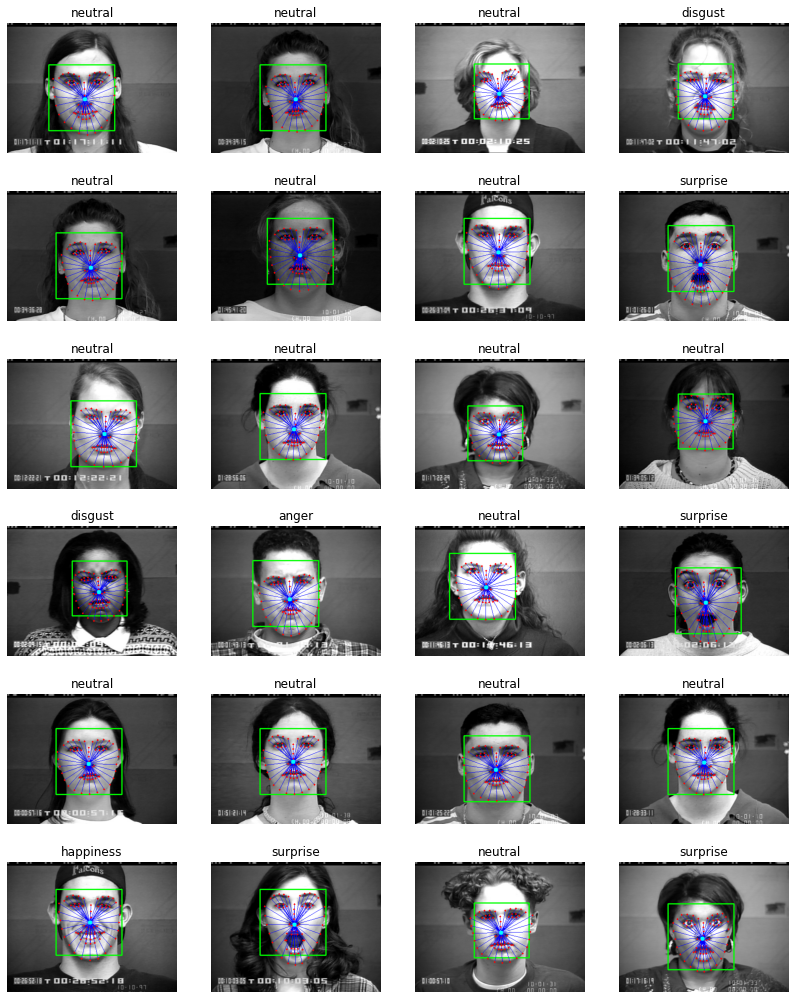

CPU times: total: 1min 42s
Wall time: 1min 41s


In [17]:
%%time
rand = random.sample(range(df.shape[0]), 24)
fig = plt.figure(figsize=(14, 18))
i = 0

print('Processed: ', end='')
for filename, row in df.iterrows():
    i += 1
    if not i % 100:
        print(i, end='.' if i==df.shape[0]//100*100 else ', ')    
        
    vectors, coords = [], []
        
    # load the input image, resize it, and convert it to grayscale
    image = cv2.imread('%sck/%s/%s' % (data_path, row['mood'], filename))
    image = imutils.resize(image, width=400)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)

    # detect faces & facial landmarks
    rect = detector(gray, 1)[0]
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    # draw bounding box
    (x,y,w,h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)

    # get center of gravity (COG)
    cog = tuple(shape.mean(axis=0).astype(int)) # get center of gravity (COG)            

    # draw (x,y)-coordinates for the facial landmarks on image
    for (x,y) in shape:
        cv2.line(image, (x,y), cog, (0,0,255), 1) # draw vector lines
        cv2.circle(image, (x,y), 2, (255,0,0), -1) # image, center-coords, radius, colour, thickness(fill)
        cv2.circle(image, cog, 5, (0,255,255), -1)
        vectors.append([mag(cog, (x,y)), angle(cog, (x,y))])
        coords.append([x,y])
                        
    # show
    if i in rand:        
        fig.add_subplot(6, 4, rand.index(i)+1)
        plt.title(row['mood'])
        plt.axis("off")
        plt.imshow(image)
            
    # store inputs in dataset
    vectors = np.array(vectors)
    vectors[:,0] /= max(vectors[:,0]) # normalize magnitudes
    vectors[:,1] = (vectors[:,1] + pi) / (2*pi) # normalize direction
    vectors = vectors.reshape(-1)
    if len(vectors) == 136:
        df.loc[filename, 'vectors'] = ' '.join(str(e) for e in vectors)
    
    coords = np.array(coords)
    coords -= np.c_[min(coords[:,0]), min(coords[:,1])]
    coords = coords / np.c_[max(coords[:,0]), max(coords[:,1])]
    coords = coords.reshape(-1)
    if len(coords) == 136:
        df.loc[filename, 'coords'] = ' '.join(str(e) for e in coords)
        
plt.show()

Processed: 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000.

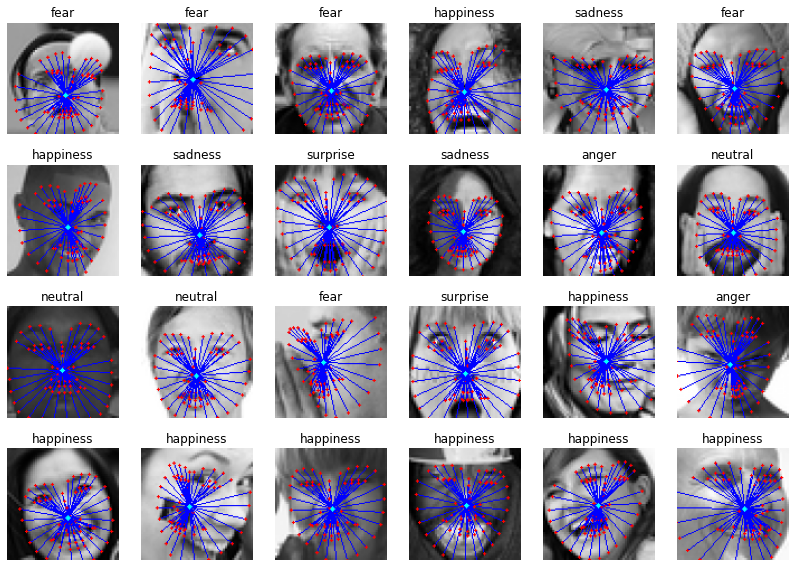

CPU times: total: 2min 32s
Wall time: 2min 33s


In [31]:
%%time
width = 100
rand = random.sample(range(df.shape[0]), 24)
fig = plt.figure(figsize=(14, 10))

print('Processed: ', end='')
for i in range(len(X)):
    if not (i+1) % 1000:
        print(i+1, end='.' if i+1==len(X)//1000*1000 else ', ')
    vectors, coords = [], []
    
    image = np.uint8(X[i])
    image = imutils.resize(image, width=width)
    gray = cv2.equalizeHist(image)    
    image = np.dstack((image,image,image))
    
    # convert canvas to bounding box
    rect = dlib.rectangle(left=0, top=0, right=width-1, bottom=width-1)
    
    # determine facial landmarks for face region
    shape = predictor(gray, rect) 
    shape = face_utils.shape_to_np(shape)

    # get center of gravity (COG)
    cog = tuple(shape.mean(axis=0).astype(int)) 

    # draw (x,y)-coordinates for the facial landmarks on image
    for (x,y) in shape:
        cv2.line(image, (x,y), cog, (0,0,255), 1) # draw vector lines
        cv2.circle(image, (x,y), 1, (255,0,0), -1) # image, center-coords, radius, colour, thickness(fill)
        cv2.circle(image, cog, 2, (0,255,255), -1)
        vectors.append([mag(cog, (x,y)), angle(cog, (x,y))])
        coords.append([x,y])
        
    # show
    if i in rand:        
        fig.add_subplot(4, 6, rand.index(i)+1)
        plt.title(moods[Y[i]])
        plt.axis("off")
        plt.imshow(image)
            
    # store inputs in dataset
    vectors = np.array(vectors)
    vectors[:,0] /= max(vectors[:,0]) # normalize magnitudes
    vectors[:,1] = (vectors[:,1] + pi) / (2*pi) # normalize direction
    vectors = vectors.reshape(-1)
    if len(vectors) == 136:
        df.loc[i, 'vectors'] = ' '.join(str(e) for e in vectors)
    
    coords = np.array(coords)
    coords -= np.c_[min(coords[:,0]), min(coords[:,1])]
    coords = coords / np.c_[max(coords[:,0]), max(coords[:,1])]
    coords = coords.reshape(-1)
    if len(coords) == 136:
        df.loc[i, 'coords'] = ' '.join(str(e) for e in coords)

plt.show()

# Filter Data

In [18]:
df = df[(df['vectors']!='') & (df['coords']!='')]
print(df.shape[0])
display(df.head())

902


,mood,vectors,coords
filename,,,
S010_004_00000019.png,anger,0.913848522815577 0.07291733991580246 0.825733...,0.0 0.20408163265306123 0.006622516556291391 0...
S011_004_00000021.png,anger,1.0 0.06939233223948903 0.9018695583426973 0.0...,0.0 0.14492753623188406 0.017964071856287425 0...
S014_003_00000030.png,anger,0.9226796499775556 0.07379180882521665 0.82635...,0.0 0.16428571428571428 0.0125 0.3142857142857...
S022_005_00000032.png,anger,1.0 0.06789987439004594 0.8821328104551961 0.0...,0.0 0.19834710743801653 0.023622047244094488 0...
S026_003_00000015.png,anger,1.0 0.08154931539664242 0.8700847531963809 0.0...,0.0 0.09345794392523364 0.024193548387096774 0...


# Save Data

In [19]:
df.to_csv(data_path + 'ck/vector_coords_norm.csv')